In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download gpiosenka/100-bird-species

 99% 1.48G/1.49G [00:09<00:00, 218MB/s]
100% 1.49G/1.49G [00:10<00:00, 160MB/s]


In [ ]:
! unzip 100-bird-species.zip -d '/content/drive/MyDrive/data'

In [ ]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm
import pandas as pd

import torchvision.models as models

resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    data_root = '/content/drive/MyDrive/data'  # get data root path
    image_path = os.path.join(data_root)  # data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)


    bird_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in bird_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('/content/drive/MyDrive/model/class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 256
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "valid"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = resnet50
    # load pretrain weights
    # download url: https://download.pytorch.org/models/resnet50-19c8e357.pth
    # model_weight_path = r'resnet50-19c8e357.pth'
    # assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
    # net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
    for param in net.parameters():
        param.requires_grad = False

    # change fc layer structure
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel, 400)
    net.to(device)

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.001)

    epochs = 10
    best_acc = 0.0
    save_path = '/content/drive/MyDrive/model/resNet50.pth'
    train_steps = len(train_loader)

    train_loss = []
    train_acc = [
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        num_correct = 0.0 
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits = net(images.to(device))
            loss = loss_function(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            pred = torch.max(logits, dim=1)[1]
            num_correct += torch.eq(pred, labels.to(device)).sum().item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        vali_loss = 0.0  
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                loss = loss_function(outputs, val_labels.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
                vali_loss += loss.item()  

                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                           epochs)

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f  val_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, num_correct / len(train_loader.dataset), vali_loss / len(validate_loader), val_accurate))
        
        train_loss.append(running_loss / train_steps)
        val_acc.append(val_accurate)
        train_acc.append(num_correct / len(train_loader.dataset))  
        val_loss.append(vali_loss / len(validate_loader))  

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')
    return train_loss, train_acc, val_loss, val_acc

if __name__ == '__main__':
    train_loss, train_acc, val_loss, val_acc = main()

using cuda:0 device.
Using 2 dataloader workers every process
using 58388 images for training, 2000 images for validation.
valid epoch[1/10]: 100%|██████████| 8/8 [10:37<00:00, 79.65s/it]
[epoch 1] train_loss: 3.229  train_accuracy: 0.428  val_loss: 1.082  val_accuracy: 0.814
valid epoch[2/10]: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
[epoch 2] train_loss: 1.593  train_accuracy: 0.673  val_loss: 0.623  val_accuracy: 0.874
valid epoch[3/10]: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]
[epoch 3] train_loss: 1.297  train_accuracy: 0.712  val_loss: 0.472  val_accuracy: 0.903
valid epoch[4/10]: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
[epoch 4] train_loss: 1.163  train_accuracy: 0.735  val_loss: 0.405  val_accuracy: 0.912
valid epoch[5/10]: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]
[epoch 5] train_loss: 1.089  train_accuracy: 0.744  val_loss: 0.349  val_accuracy: 0.913
valid epoch[6/10]: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]
[epoch 6] train_loss: 1.030  train_accurac

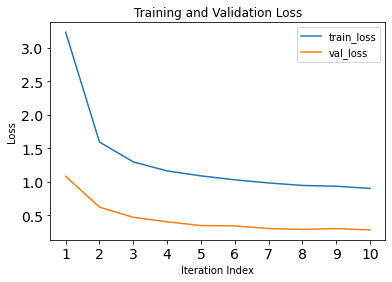

In [ ]:
df_loss = pd.DataFrame(data = {'train_loss':train_loss, 'val_loss':val_loss}, index = [1,2,3,4,5,6,7,8,9,10] )
df_loss.plot(xticks=[1,2,3,4,5,6,7,8,9,10], title='Training and Validation Loss', fontsize=14, xlabel='Iteration Index', ylabel='Loss')

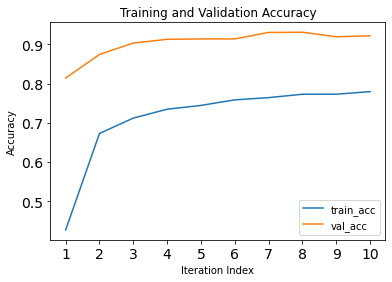

In [ ]:
df_acc = pd.DataFrame(data = {'train_acc':train_acc, 'val_acc':val_acc}, index = [1,2,3,4,5,6,7,8,9,10] )
df_acc.plot(xticks=[1,2,3,4,5,6,7,8,9,10], title='Training and Validation Accuracy', fontsize=14, xlabel='Iteration Index', ylabel='Accuracy')